# Using Neural Networks to Predict Horse Survival

https://github.com/rrazz247/Horsing-around-NN

### Problem Description

The goal of this project is to use neural networks to predict the survival of horses who had veterinarian visits for colic (abdominal pain that can in some cases be life-threatening). There are 27 features in the dataset that will be used to predict the target variable, `outcome`. This is a categorical variable with three levels: lived, died, and euthanized. The predictor variables include various clinical metrics and observations, including heart rate, temperature, breathing rate, and capillary refill time, among others. A full description of the columns can be found in the `datadict.txt` file. I downloaded the dataset from kaggle:

https://www.kaggle.com/datasets/uciml/horse-colic

For the `outcome` target variable, I will reclassify 'euthanized' to 'died' to turn this into a binary classification problem. I plan to solve this using a feed-forward neural network.

### Exploratory Data Analysis

First, I will load the required libraries and load the dataset.

In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score


In [2]:
data = pd.read_csv("./horse.csv")

In [3]:
data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

The data contains 299 rows with 28 columns. A big problem with this dataset is its small size, but also that there are many missing values. For example, the `nasogastric_reflux_ph` column, there are only 53 non-null entries out of almost 300. So I will need to impute a lot of data here.

First, I will get counts for the target variable `outcome` and visualize them in a bar plot. There are 178 lived cases, 77 died, and 44 euthanized. I plan to reclassify the euthanized cases as died, which wil make the two resulting classes, lived and died, more balanced.

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64


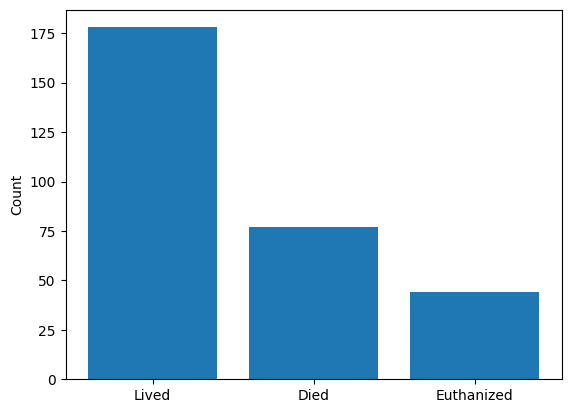

In [5]:
outcome_counts = data['outcome'].value_counts()
print(outcome_counts)

plt.bar(outcome_counts.index, outcome_counts.values)
plt.xticks(ticks=[0, 1, 2], labels=['Lived', 'Died', 'Euthanized'], rotation=0)
plt.ylabel("Count")
plt.show()

To get a sense of which variables might be important in determining horse survival, I first visualized some measures that I think would be key: heart rate and temperature. From the below scatter plot, it is clear that horses that died tended to have higher heart rates. It also seems that the variability in the rectal temperature is wider in the horses that died compared to the horses that survived.

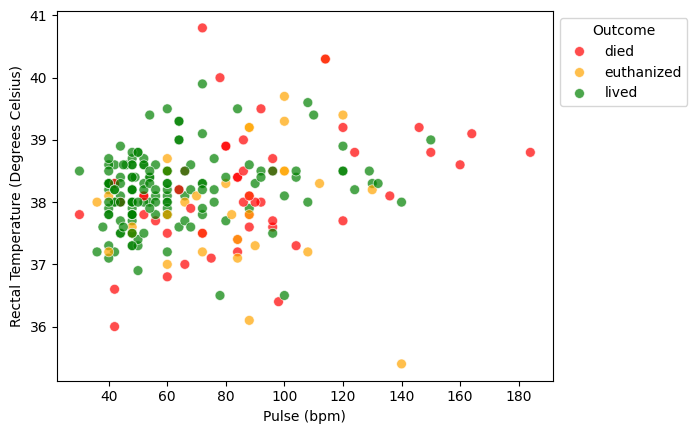

In [6]:
palette = {'lived': 'green', 'died': 'red', 'euthanized': 'orange'}

sns.scatterplot(x='pulse', y='rectal_temp', palette=palette, hue='outcome', data=data, s=50, alpha=0.7)

plt.xlabel("Pulse (bpm)")
plt.ylabel("Rectal Temperature (Degrees Celsius)")
plt.legend(title='Outcome', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Similarly, I visualized heart rate and respiratory rate. Again, it seems that the horse that died had roughly higher respiratory rates compared to those that survived.

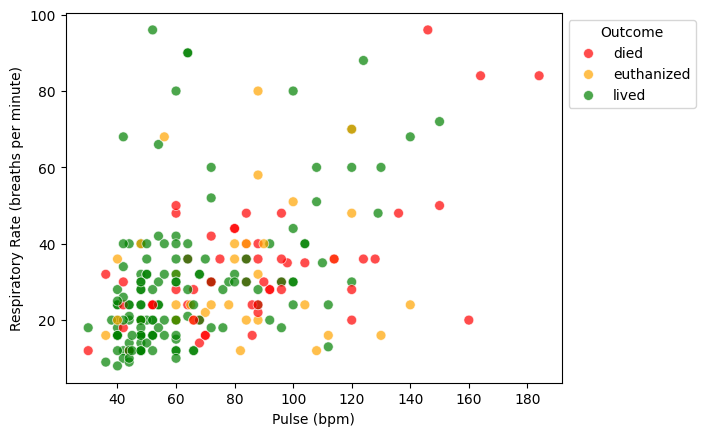

In [7]:
palette = {'lived': 'green', 'died': 'red', 'euthanized': 'orange'}

sns.scatterplot(x='pulse', y='respiratory_rate', palette=palette, hue='outcome', data=data, s=50, alpha=0.7)

plt.xlabel("Pulse (bpm)")
plt.ylabel("Respiratory Rate (breaths per minute)")
plt.legend(title='Outcome', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

I also wanted to visualize a categorical variable. Below is a bar plot of surgery status (whether the horse got a surgery done or not), colored by the outcome. There is a higher proportion of horses that died among those that underwent surgery. This makes sense, as only the severe cases would be considered for surgery, and therefore those cases are naturally at higher risk of dying. The surgery itself would likely have risks as well.

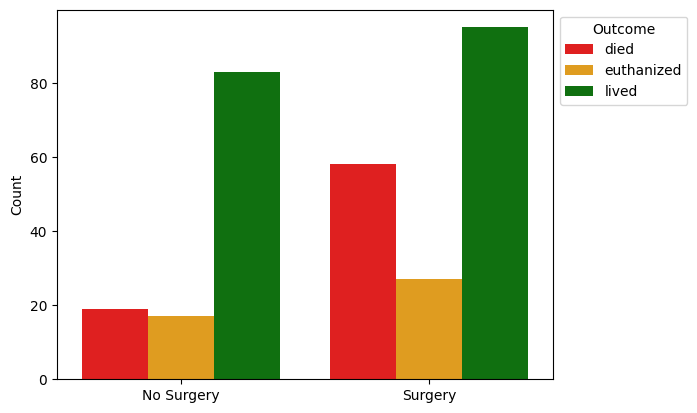

In [8]:
sns.countplot(x='surgery', hue='outcome', data=data, palette=palette)

plt.ylabel("Count")
plt.xlabel("")
plt.xticks(ticks=[0, 1], labels=['No Surgery', 'Surgery'], rotation=0)
plt.legend(title='Outcome', bbox_to_anchor=(1,1), loc='upper left')
plt.show()

Now I will clean and reformat the data. First, as I previously discussed, I will reclassify 'euthanized' as 'died'. I also removed irrelevant columns including hospital_number and cp_data, which is a binary variable indicating whether pathology data is present (since there are no pathology images in this dataset, that information is not relevant).

In [9]:
data = data.drop(columns=['hospital_number', 'cp_data'])
data['outcome'] = data['outcome'].replace('euthanized', 'died')

As observed above, there are many columns with missing values. For the numeric columns, I decided to impute the mean value for that column. For the categorical columns, I imputed missing values with the most common category in that column.

In [ ]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())

categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

Next, I converted the categorical variables into indicator variables using the `pd.get_dummies()` function, and I standardized the numeric variables.

In [ ]:
categorical_cols = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion']

data = pd.get_dummies(data, columns=, 
                      drop_first=True)

label_encoder = LabelEncoder()
data['outcome'] = label_encoder.fit_transform(data['outcome'])

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

Finally, I seperated the target variable `outcome` from the predictor variables and split the data into a training and testing set at a 80/20 ratio.

In [ ]:
X = data.drop(columns=['outcome'])
y = data['outcome']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=222)

The final training set has 49 predictor variables.

In [14]:
X_train.head()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,...,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,surgical_lesion_yes
263,0.200694,-1.021059,-0.597733,0.000000,-0.233087,-0.689963,1.195329,-0.268679,-0.139371,-0.057928,...,False,False,True,False,False,False,False,True,False,True
261,0.658966,0.583463,-0.155463,0.000000,-1.142240,-0.713254,0.000000,-0.677797,-0.139371,-0.057928,...,False,False,False,False,False,False,False,True,False,False
238,-0.104821,-0.072933,-0.534551,0.000000,-1.041223,1.580873,0.000000,-0.084214,-0.139371,-0.057928,...,False,False,False,False,False,False,False,True,False,True
29,-0.715851,-0.875194,0.000000,0.000000,-0.132070,2.007868,0.000000,-0.677797,-0.139371,-0.057928,...,False,False,False,False,False,False,False,True,False,False
90,-0.257578,-0.729328,-0.913640,-4.484859,0.676066,2.396046,0.000000,-0.247750,-0.139371,-0.057928,...,False,False,True,False,False,True,False,True,False,True


### Analysis

I will use a feed-forward neural network to solve this binary classification problem. Below I use the `Sequential()` function from keras. The input shape is 49, as there are 49 columns in the cleaned and processed training set. Then, I put three dense hidden layers with 128 neurons, 64 neurons, and 32 neurons, all using rectified linear activation functions. I also added dropout layers for the first two hidden layers to control potential overfitting. Finally, the output layer is a single neuron with sigmoid activation, as this network will be solving a binary classification task. A summary of this model is shown below.

In [38]:
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

Next, I compile the model using binary crossentropy as the loss function, and the Adam optimizer. Here I specified an initial learning rate of 1e-4. I will optimize this value later on.

In [39]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

Finally, I trained the model over 100 epochs, and graphed both the validation and training accuracy, and the validation and training loss over the epochs.

In [ ]:
# Train

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3958 - loss: 0.7987 - val_accuracy: 0.4583 - val_loss: 0.7217
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3938 - loss: 0.8392 - val_accuracy: 0.4792 - val_loss: 0.7133
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3941 - loss: 0.8068 - val_accuracy: 0.3958 - val_loss: 0.7064
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4153 - loss: 0.7624 - val_accuracy: 0.4792 - val_loss: 0.7006
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3888 - loss: 0.7591 - val_accuracy: 0.4583 - val_loss: 0.6955
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5155 - loss: 0.7487 - val_accuracy: 0.4792 - val_loss: 0.6908
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4109 - loss: 0.7943 - val_accuracy: 0.5417 - val_loss: 0.6865
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4878 - loss: 0.7407 - val_accuracy: 0.5417 - val_loss: 0.6825

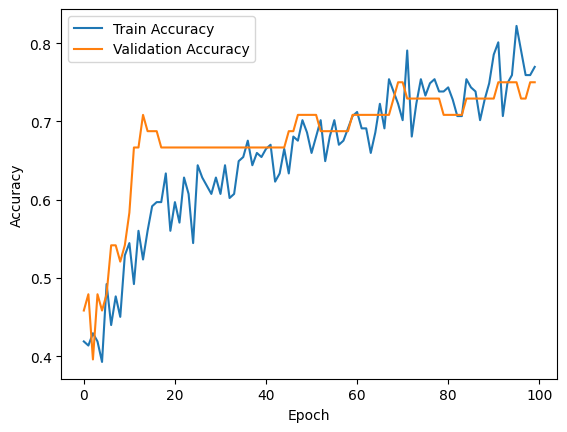

In [41]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The above accuracy graph looks reasonable, as the training and validation accuracies are both steadily increasing.

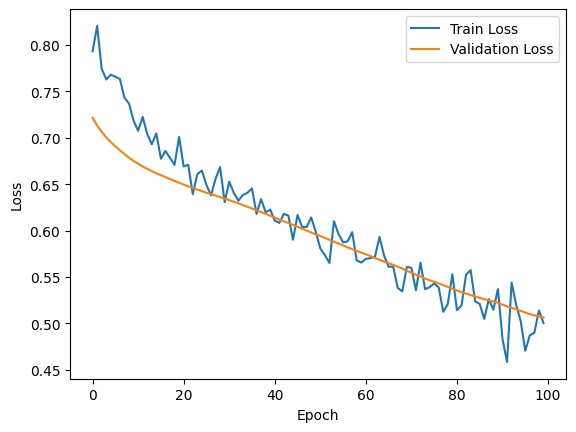

In [42]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The above loss graph looks reasonable as well, as the training and validation losses are decreasing at roughly the same rate. However, it looks like the model could improve, as the validation loss and validation accuracy had not quite reached their highest points (the graphs do not seem to have flattened out yet). I can optimize this by tuning the learning rate.

### Results

To optimize the performance of this model, I will try a few different learning rates. A higher learning rate will train the model faster at the risk of overfitting. A smaller learning rate will traing the model slower, but risks not reaching the optimal performance.

The initial model I fit used a learning rate of 1e-4. Here I will try a smaller learning rate of 1-e5. I also increased the number of epochs to give the slower learning time to converge.

In [ ]:
# Learning rate 1e-5

model2 = Sequential()

model2.add(Input(shape=(X_train.shape[1],)))

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation='relu'))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

history2 = model2.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4155 - loss: 0.8872 - val_accuracy: 0.4375 - val_loss: 0.7296
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4076 - loss: 0.8030 - val_accuracy: 0.4375 - val_loss: 0.7287
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4476 - loss: 0.8449 - val_accuracy: 0.4375 - val_loss: 0.7277
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4065 - loss: 0.8510 - val_accuracy: 0.4375 - val_loss: 0.7268
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3917 - loss: 0.8632 - val_accuracy: 0.4583 - val_loss: 0.7258
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3854 - loss: 0.8453 - val_accuracy: 0.4583 - val_loss: 0.7249
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3780 - loss: 0.8524 - val_accuracy: 0.4792 - val_loss: 0.7240
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4020 - loss: 0.8303 - val_accuracy: 0.4792 - val_loss: 0.7232

Here the validation accuracy has worsened--the validation accuracy from the original model was 0.75, while here it is 0.6042.

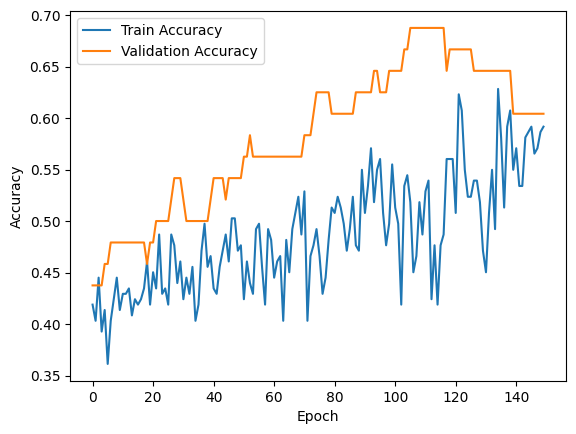

In [44]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

While the training accuracy seems to be increasing, the validation accuracy reached a peak accuracy of nearly 0.7 before dipping back down to around 0.6. This is not ideal and suggests that the training has gone on too long.

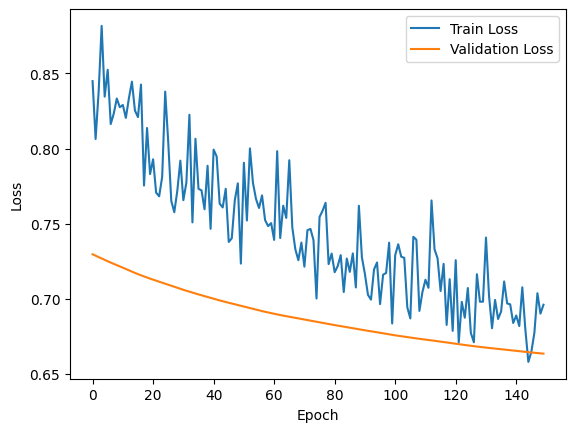

In [45]:
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both training and validation losses are decreasing, though it seems that the validation loss is beginning to level out.

From this trial, it seems that the learning rate 1e-4 is better than 1e-5. Next, I will try instead increasing the learning rate a bit to 2e-4.

In [ ]:
# Learning rate 2e-4

model3 = Sequential()

model3.add(Input(shape=(X_train.shape[1],)))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(32, activation='relu'))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])

history3 = model3.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4724 - loss: 0.7246 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5036 - loss: 0.7062 - val_accuracy: 0.5417 - val_loss: 0.6887
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5331 - loss: 0.6890 - val_accuracy: 0.5833 - val_loss: 0.6830
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4342 - loss: 0.7225 - val_accuracy: 0.6250 - val_loss: 0.6767
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5644 - loss: 0.6716 - val_accuracy: 0.6667 - val_loss: 0.6712
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6426 - loss: 0.6663 - val_accuracy: 0.6875 - val_loss: 0.6658
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6838 - loss: 0.6485 - val_accuracy: 0.6875 - val_loss: 0.6603
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6452 - loss: 0.6528 - val_accuracy: 0.7083 - val_loss: 0.6555

At the end of the 100 epochs, the training accuracy and the validation accuracy have reached 0.79. This is the best result so far, and it is good that the accuracies for training and validation have reached nearly identical levels.

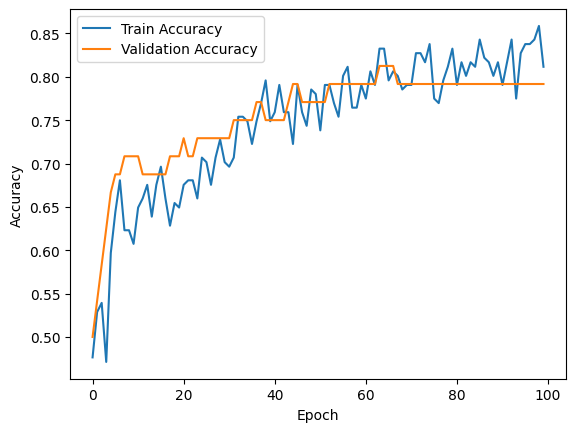

In [33]:
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The accuracy plot looks reasonable, with the validation accuracy having reached a peak around 0.8 and not increasing or decreasing further, while the training accuracy is only very slightly increasing, if at all.

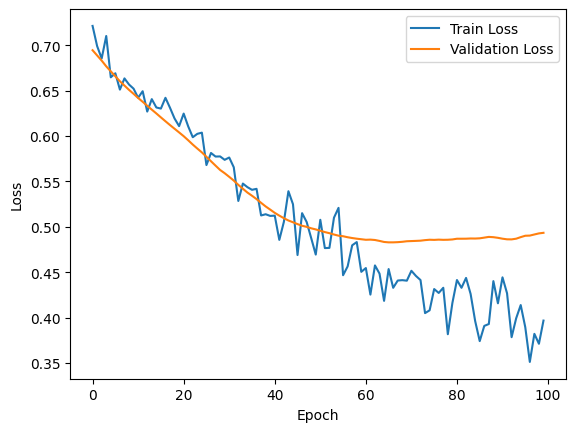

In [34]:
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both the training and validation losses decreased at the same rate near the beginning of the training, but then diverged around epoch 60. The training loss continued to decrease, while the validation loss leveled out and even began to rise a little, which may be indicative of some overfitting.

I will use this final model, with learning rate 2e-4, to make predictions on the testing dataset. The resulting test accuracy was 0.65, which is not great, and it is notably lower than both the training and validation accuracies, which had each reached nearly 0.8. This result suggets that the model indeed may be overfitting a bit. 

In [36]:
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0.65


### Conclusions

The goal of this project was to was to train a neural network to predict the survival of horses with colic. I was only partially succesful in this task. While I was able to train a neural network on the data, and got fairly reasonable training and validation accuracies of 0.79, the model did not do quite as well as on the completely unseen test data, yielding predictions with an accuracy of 0.65. This discrepancy may be explained in that the model was overfitting the training data. Examining the training and validation losses during training also steers me to that conclusion, as the training loss continued to decrease while the validation loss flattened out, and then began to increase a little toward the final epochs.

Overall, to improve the performance of this neural network binary classifier model, I think the most effective approach would be to obtain some more data, ideally of higher quality than the present set. Only about 300 data points, split between training, validation, and testing sets, simply may not be enough to get robust, consistent results. Another problem is that there were many missing values in this data. It may have been better to simply remove some of the variables that had mostly missing values, instead of just imputing those values. I would also like to experiment with different model architectures, by increasing or decreasing the number of neurons in the hidden layers, adding or removing the layers themselves, and adding dropout layers or regularizers.